# seqFISH Mouse Organogenesis Imputed

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>)
- **Date of Creation:** 01.08.2024
- **Date of Last Modification:** 01.08.2024

## 1. Setup

Run this notebook in the nichecompass-reproducibility environment, installable from ```('../../../envs/environment.yaml')```.

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
import os
import warnings

import anndata as ad
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import squidpy as sq
from nichecompass.models import NicheCompass
from nichecompass.utils import create_new_color_dict

from analysis_utils import plot_category_in_latent_and_physical_space

In [84]:
import sys
sys.path.append("../../utils")

### 1.2 Define Parameters

In [82]:
dataset = "seqfish_mouse_organogenesis_imputed"
species = "mouse"
model_label = "reference_query"
counts_key = "counts"
cat_covariates_keys = "batch"
gp_names_key = "nichecompass_gp_names"
spatial_key = "spatial"
adj_key = "spatial_connectivities"
n_neighbors = 8
latent_key = "nichecompass_latent"
sample_key = "sample"
spot_size = 0.05 

load_timestamp = "31072024_212252_2"
batches = ["batch1", "batch2", "batch3", "batch4", "batch5", "batch6"]

### 1.3 Run Notebook Setup

In [70]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 1.4 Configure Paths and Create Directories

In [99]:
# Define paths
ga_data_folder_path = "../../datasets/ga_data"
gp_data_folder_path = "../../datasets/gp_data"
st_data_folder_path = "../../datasets/st_data"
st_data_gold_folder_path = st_data_folder_path + "/gold"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../../artifacts"
model_folder_path = f"{artifacts_folder_path}/{dataset}/models/{model_label}/{load_timestamp}"
figure_folder_path = f"{artifacts_folder_path}/{dataset}/figures/{model_label}/{load_timestamp}"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(result_folder_path, exist_ok=True)

NameError: name 'os' is not defined

## 2. Model

In [72]:
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name=f"{dataset}_{model_label}.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
CATEGORICAL COVARIATES EMBEDDINGS INJECTION -> ['gene_expr_decoder']
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 5000, n_cat_covariates_embed_input: 0, n_hidden: 1956, n_latent: 1856, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 1856, n_addon_gp_input: 100, n_cat_covariates_embed_input: 3, n_output: 5000
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 1856, n_addon_gp_input: 100, n_cat_covariates_embed_input: 3, n_output: 5000


In [73]:
model.adata

AnnData object with n_obs × n_vars = 52568 × 5000
    obs: 'Area', 'celltype_mapped_refined', 'sample', 'batch', 'mapping_entity'
    uns: 'nichecompass_genes_idx', 'nichecompass_gp_names', 'nichecompass_latent', 'nichecompass_source_genes_idx', 'nichecompass_target_genes_idx', 'umap'
    obsm: 'X_umap', 'nichecompass_latent', 'spatial'
    varm: 'nichecompass_gp_sources', 'nichecompass_gp_targets'
    layers: 'counts'
    obsp: 'nichecompass_latent_connectivities', 'nichecompass_latent_distances', 'spatial_connectivities'

In [94]:
latent_leiden_resolution = 0.25
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"

In [95]:
samples = model.adata.obs[sample_key].unique().tolist()

In [96]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [97]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="default",
    cat_key=latent_cluster_key)

FileNotFoundError: [Errno 2] No such file or directory: '../../artifacts/seqfish_mouse_organogenesis_imputed/figures/reference_query/31072024_212252_2/res_0.3_latent_clusters_latent_physical_space.svg'

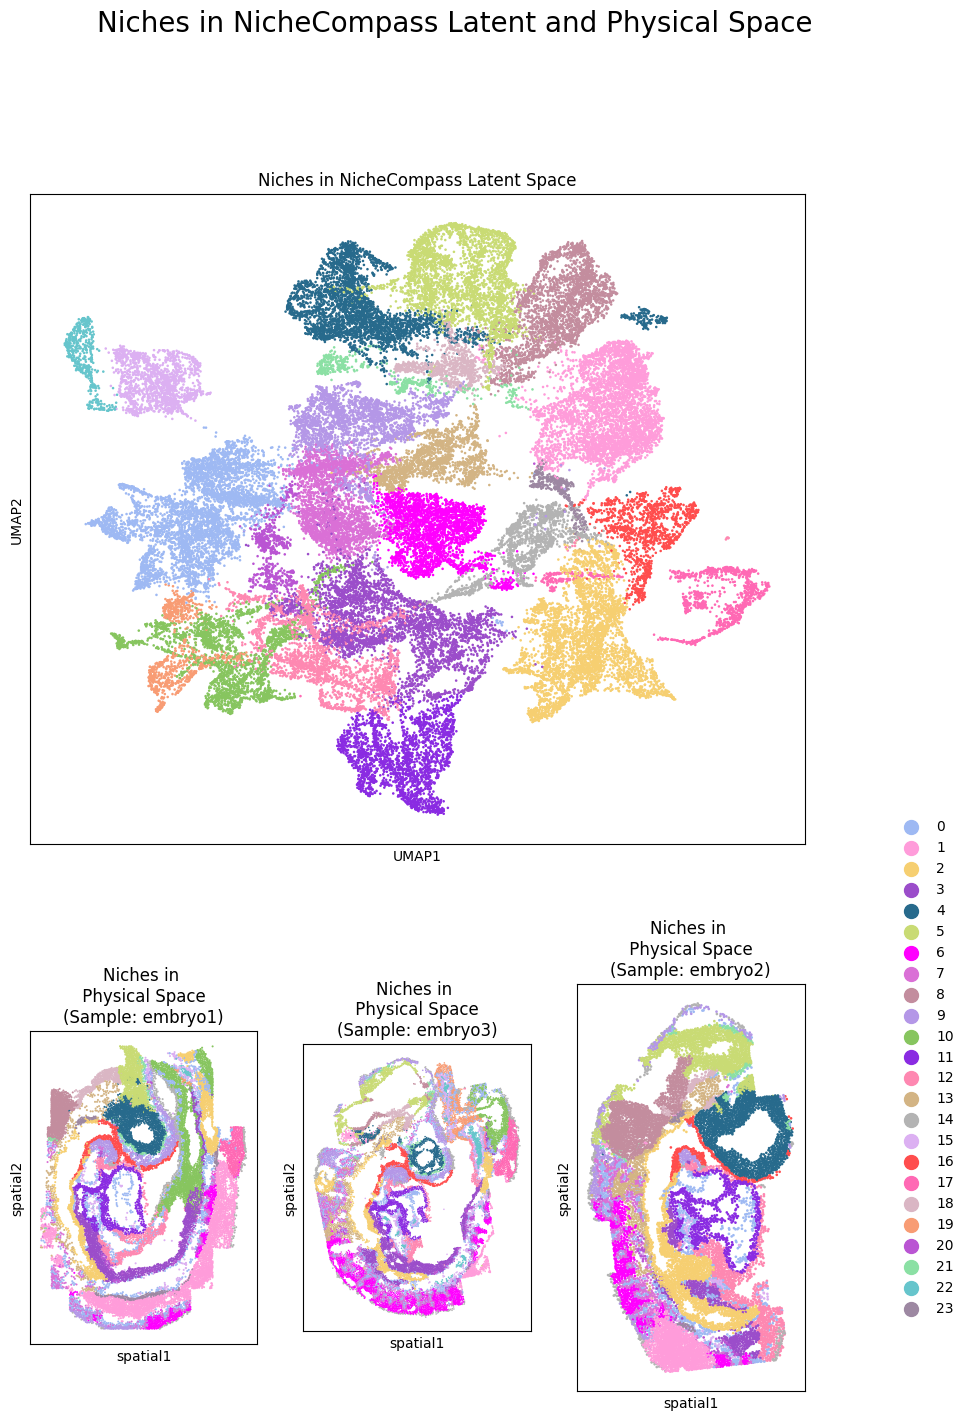

In [93]:
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key=latent_cluster_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=latent_cluster_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)